# Statistical analysis of water discharge of surface streams

Large amounts of historical surface water data are available from the United States Geological Survey (USGS) at https://waterdata.usgs.gov/nwis The goal of the project is to retrieve samples from the web interface manually, and then later  automate the process by calling the web service as described at https://help.waterdata.usgs.gov/faq/automated-retrievals.

In [2]:
import pandas as pd
#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.optimize import curve_fit
from scipy import signal
from scipy import stats
import math as math
import pycurl
from io import BytesIO

## Excercise 1

For the purposes of the current excercises, select a stream from a rainy area with relatively small discharge so that the effect of short but strong storms is visible. Good choices are small rivers from the north-eastern US, e.g. site 01589440. Retrieve at least 10 years of data.

In [3]:
def get_site_url( site_number='01589440', date_from="2008-01-01", date_to="2017-12-31" ): 
    # input: site_number is a string
    # the parameters in the url can have different formats. cb_00065 is the same as parameterCd=00060
    
    #url = 'https://nwis.waterdata.usgs.gov/nwis/uv/?cb_00065=on&format=rdb&site_no=%s&period=&begin_date=%s\
#&end_date=%s&siteStatus=all'%(site_number, date_from, date_to)

    url = 'https://nwis.waterdata.usgs.gov/nwis/uv/?parameterCd=00060,00065&format=rdb&site_no=%s&period=&begin_date=%s\
&end_date=%s&siteStatus=all'%(site_number, date_from, date_to)
    return url

def download_data_from_url( url, savename='test.csv' ):
    ''' 
    One can download data with a different method that supports resume. If data is two large then it takes
    lot of time and the connection to the server might be interrupted.
    '''
    
    buffer = BytesIO()
    c = pycurl.Curl()
    c.setopt(c.URL, url)
    c.setopt(c.WRITEDATA, buffer)
    c.perform()
    c.close()

    body = buffer.getvalue() # Body is a byte string.
    with open( savename, 'w' ) as output:
        output.write( body.decode('utf-8')) # We have to know the encoding in order to print it to a text file

## Excercise 2

Load the downloaded data file into the processing environment paying attention to handling time stamps and perfoming the necessary data type conversions. Converting dates to floating point numbers such as unix time stamp or julian date usually makes handling time series easier. Plot the data for a certain interval to show that the effect of storms is clearly visible.

In [4]:
site_number = '01589440'
date_from = "2008-01-01"
date_to = "2017-12-31"
url = get_site_url(site_number, date_from, date_to)
download_data_from_url(url, "%s.csv"%site_number)


In [5]:
!head -n 40 01589440.csv

# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database
# may not have received Director's approval. Any such data values are qualified
# as provisional and are subject to revision. Provisional data are released on the
# condition that neither the USGS nor the United States Government may be held liable
# for any damages resulting from its use.
#
# Additional info: https://help.waterdata.usgs.gov/policies/provisional-data-statement
#
# File-format description:  https://help.waterdata.usgs.gov/faq/about-tab-delimited-output
# Automated-retrieval info: https://help.waterdata.usgs.gov/faq/automated-retrievals
#
# Contact:   gs-w_support_nwisweb@usgs.gov
# retrieved: 2019-06-08 10:32:13 EDT       (nadww01)
#
# Data for the following 1 site(s) are contained in this file
#    USGS 01589440 JONES FALLS AT SORRENTO, MD
# -------------------------------------------------------------

In [6]:
data = pd.read_csv("01589440.csv", sep='\t', comment='#', header=0, skiprows=[30], parse_dates=[2])
#data = pd.read_csv("01589440.csv", sep='\t', comment='#', header=0, skiprows=[31], parse_dates=[2])


In [7]:
data.head()

,agency_cd,site_no,datetime,tz_cd,69744_00060,69744_00060_cd,69745_00065,69745_00065_cd
0,USGS,1589440,2008-01-01 00:00:00,EST,18.5,A,3.49,A
1,USGS,1589440,2008-01-01 00:15:00,EST,18.5,A,3.49,A
2,USGS,1589440,2008-01-01 00:30:00,EST,18.5,A,3.49,A
3,USGS,1589440,2008-01-01 00:45:00,EST,18.5,A,3.49,A
4,USGS,1589440,2008-01-01 01:00:00,EST,18.5,A,3.49,A


In [8]:
data.tail()

,agency_cd,site_no,datetime,tz_cd,69744_00060,69744_00060_cd,69745_00065,69745_00065_cd
347684,USGS,1589440,2017-12-31 22:45:00,EST,NaN,NaN,3.36,A
347685,USGS,1589440,2017-12-31 23:00:00,EST,NaN,NaN,3.37,A
347686,USGS,1589440,2017-12-31 23:15:00,EST,NaN,NaN,3.37,A
347687,USGS,1589440,2017-12-31 23:30:00,EST,NaN,NaN,3.37,A
347688,USGS,1589440,2017-12-31 23:45:00,EST,NaN,NaN,3.37,A


In [9]:
data.T.head()

,0,1,2,3,4,5,6,7,8,9,...,347679,347680,347681,347682,347683,347684,347685,347686,347687,347688
agency_cd,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,...,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS,USGS
site_no,1589440,1589440,1589440,1589440,1589440,1589440,1589440,1589440,1589440,1589440,...,1589440,1589440,1589440,1589440,1589440,1589440,1589440,1589440,1589440,1589440
datetime,2008-01-01 00:00:00,2008-01-01 00:15:00,2008-01-01 00:30:00,2008-01-01 00:45:00,2008-01-01 01:00:00,2008-01-01 01:15:00,2008-01-01 01:30:00,2008-01-01 01:45:00,2008-01-01 02:00:00,2008-01-01 02:15:00,...,2017-12-31 21:30:00,2017-12-31 21:45:00,2017-12-31 22:00:00,2017-12-31 22:15:00,2017-12-31 22:30:00,2017-12-31 22:45:00,2017-12-31 23:00:00,2017-12-31 23:15:00,2017-12-31 23:30:00,2017-12-31 23:45:00
tz_cd,EST,EST,EST,EST,EST,EST,EST,EST,EST,EST,...,EST,EST,EST,EST,EST,EST,EST,EST,EST,EST
69744_00060,18.5,18.5,18.5,18.5,18.5,18,18,18,18,18,...,NaN,NaN,7.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#data.drop(axis=0, index=0, inplace=True)

In [11]:
#data['datetime_converted'] = pd.to_datetime(data['datetime'], errors='coerce')

type(data['datetime'].values[0])

numpy.datetime64

In [12]:
data.head()

,agency_cd,site_no,datetime,tz_cd,69744_00060,69744_00060_cd,69745_00065,69745_00065_cd
0,USGS,1589440,2008-01-01 00:00:00,EST,18.5,A,3.49,A
1,USGS,1589440,2008-01-01 00:15:00,EST,18.5,A,3.49,A
2,USGS,1589440,2008-01-01 00:30:00,EST,18.5,A,3.49,A
3,USGS,1589440,2008-01-01 00:45:00,EST,18.5,A,3.49,A
4,USGS,1589440,2008-01-01 01:00:00,EST,18.5,A,3.49,A


## Excercise 3

Plot the histogram of water discharge values. Fit the data with an appropriate distribution function and bring arguments in favor of the choice of function.

In [13]:
data.rename(columns={'69744_00060': 'Discharge'}, inplace=True)

In [14]:
data.rename(columns={'69745_00065': 'Gage height'}, inplace=True)

In [15]:
data.head()

,agency_cd,site_no,datetime,tz_cd,Discharge,69744_00060_cd,Gage height,69745_00065_cd
0,USGS,1589440,2008-01-01 00:00:00,EST,18.5,A,3.49,A
1,USGS,1589440,2008-01-01 00:15:00,EST,18.5,A,3.49,A
2,USGS,1589440,2008-01-01 00:30:00,EST,18.5,A,3.49,A
3,USGS,1589440,2008-01-01 00:45:00,EST,18.5,A,3.49,A
4,USGS,1589440,2008-01-01 01:00:00,EST,18.5,A,3.49,A


In [16]:
import matplotlib.pyplot as plt
data['Discharge'].hist(bins = 100)

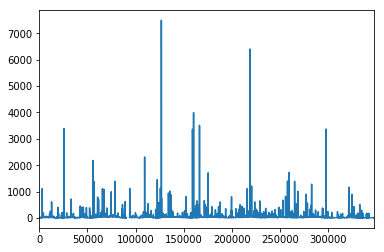

In [17]:
data['Discharge'].plot()

In [18]:
# x = data['Discharge'].dropna().values
# y = np.linspace(0, 7000, len(x))

# plt.bar(x,y, label = 'Water Discharge')
# plt.title('Bar char of Water Discharge')
# plt.legend()
# plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


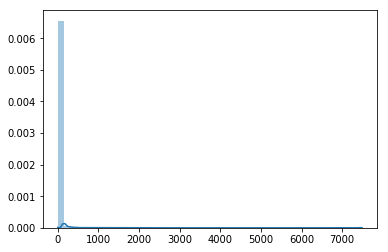

In [19]:
import seaborn as sns
sns.distplot(data['Discharge'].dropna().values)

**Normal distribution**

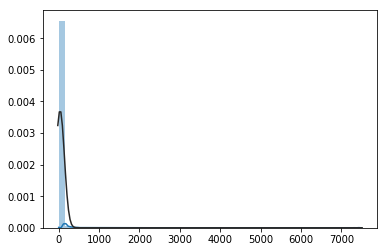

In [20]:
from scipy.stats import logistic, uniform, norm, pearsonr
sns.distplot(data['Discharge'].dropna().values, fit = norm )

**Uniform**

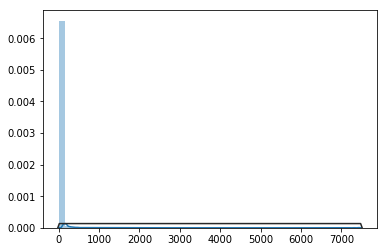

In [21]:
sns.distplot(data['Discharge'].dropna().values, fit = uniform)

**Logistic**

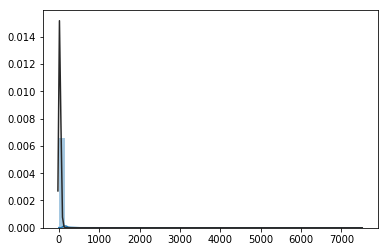

In [22]:
sns.distplot(data['Discharge'].dropna().values, fit = logistic)

In [23]:
# We can assume that the logistic is the "best" 

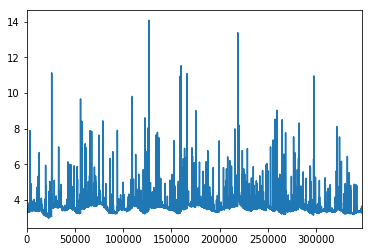

In [24]:
data['Gage height'].plot()

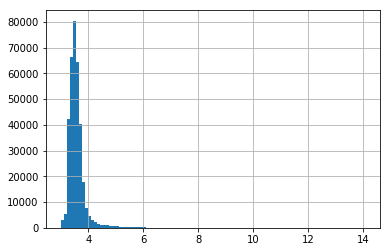

In [25]:
data['Gage height'].hist(bins = 100)

In [26]:
data['Discharge'].min(), data['Discharge'].max()

(2.79, 7490.0)

In [27]:
data.describe()

,site_no,Discharge,Gage height
count,347689.0,332390.000000,347689.000000
mean,1589440.0,34.252893,3.589110
std,0.0,107.093178,0.425206
min,1589440.0,2.790000,3.000000
25%,1589440.0,14.300000,3.400000
50%,1589440.0,21.200000,3.520000
75%,1589440.0,31.700000,3.660000
max,1589440.0,7490.000000,14.080000


In [28]:
data.describe(include='all')

,agency_cd,site_no,datetime,tz_cd,Discharge,69744_00060_cd,Gage height,69745_00065_cd
count,347689,347689.0,347689,347689,332390.000000,332390,347689.000000,347689
unique,1,NaN,347649,2,NaN,2,NaN,1
top,USGS,NaN,2009-11-01 01:45:00,EDT,NaN,A,NaN,A
freq,347689,NaN,2,226712,NaN,332360,NaN,347689
first,NaN,NaN,2008-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2017-12-31 23:45:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,1589440.0,NaN,NaN,34.252893,NaN,3.589110,NaN
std,NaN,0.0,NaN,NaN,107.093178,NaN,0.425206,NaN
min,NaN,1589440.0,NaN,NaN,2.790000,NaN,3.000000,NaN
25%,NaN,1589440.0,NaN,NaN,14.300000,NaN,3.400000,NaN


In [29]:
dict = {'A': 1, 'A:e' : 0}
data['69744_00060_cd'].map(dict).unique()

array([ 1., nan,  0.])

In [30]:
print(data[data['69744_00060_cd'] == 'A']['Discharge'].count()),
print(data[data['69744_00060_cd'] == 'A:e']['Discharge'].count())
#print(sales_data[sales_data['File_Type'] == 'Active']['SKU_number'].count())

332360
30


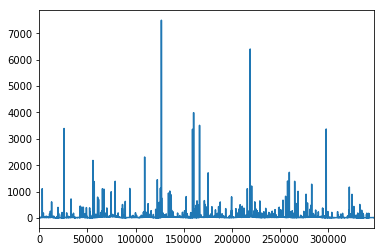

In [31]:
data[data['69744_00060_cd'] == 'A']['Discharge'].plot()

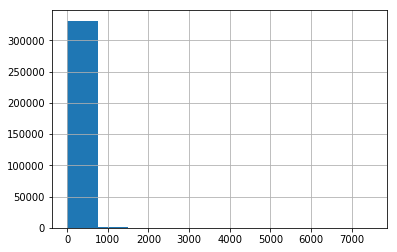

In [32]:
data[data['69744_00060_cd'] == 'A']['Discharge'].hist()

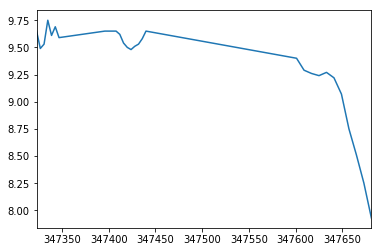

In [33]:
data[data['69744_00060_cd'] == 'A:e']['Discharge'].plot()

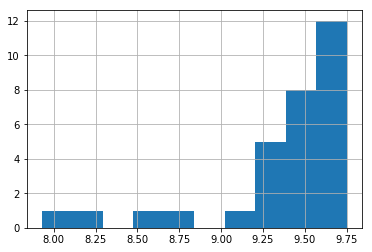

In [34]:
data[data['69744_00060_cd'] == 'A:e']['Discharge'].hist()

**For categorical data columns in our data**

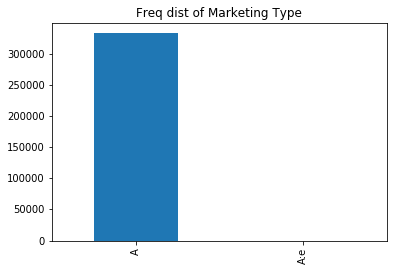

In [35]:
data['69744_00060_cd'].value_counts().plot.bar(title="Freq dist of Marketing Type")

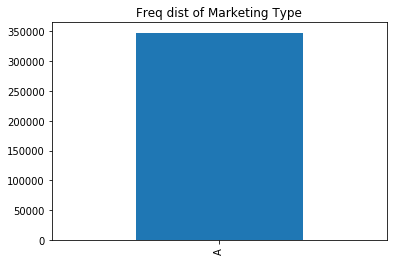

In [36]:
data['69745_00065_cd'].value_counts().plot.bar(title="Freq dist of Marketing Type")

In [37]:
data.head()

,agency_cd,site_no,datetime,tz_cd,Discharge,69744_00060_cd,Gage height,69745_00065_cd
0,USGS,1589440,2008-01-01 00:00:00,EST,18.5,A,3.49,A
1,USGS,1589440,2008-01-01 00:15:00,EST,18.5,A,3.49,A
2,USGS,1589440,2008-01-01 00:30:00,EST,18.5,A,3.49,A
3,USGS,1589440,2008-01-01 00:45:00,EST,18.5,A,3.49,A
4,USGS,1589440,2008-01-01 01:00:00,EST,18.5,A,3.49,A


**Normal distribution**

In [38]:
#define the values of water discharge

r = data['Discharge'].dropna().values
r.size

332390

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


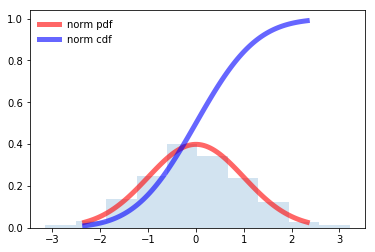

In [39]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
# Calculate a few first moments:
mean, var, skew, kurt = norm.stats(moments='mvsk')
# Display the probability density function (``pdf``):
x = np.linspace(norm.ppf(0.01),  norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.plot(x, norm.cdf(x),
       'b-', lw=5, alpha=0.6, label='norm cdf')
# Check accuracy of ``cdf`` and ``ppf``:
vals = norm.ppf([0.001, 0.5, 0.999])
np.allclose([0.001, 0.5, 0.999], norm.cdf(vals))
# True
# Generate random numbers:
r = norm.rvs(size=1000)
# And compare the histogram:
ax.hist(r, normed=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

**Uniform distribution**

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


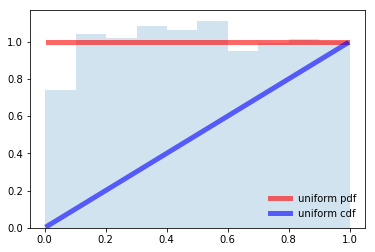

In [40]:
from scipy.stats import uniform
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
# Calculate a few first moments:
#mean, var, skew, kurt = uniform.stats(moments='mvsk')
# Display the probability density function (``pdf``):
x = np.linspace(uniform.ppf(0.01), uniform.ppf(0.99), 100)
ax.plot(x, uniform.pdf(x),'r-', lw=5, alpha=0.6, label='uniform pdf')
ax.plot(x, uniform.cdf(x),'b-', lw=5, alpha=0.6, label='uniform cdf')
# Check accuracy of ``cdf`` and ``ppf``:
vals = uniform.ppf([0.001, 0.5, 0.999])
np.allclose([0.001, 0.5, 0.999], uniform.cdf(vals))
# True
# Generate random numbers:
r = uniform.rvs(size=1000)
# And compare the histogram:
ax.hist(r, normed=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

**Logostic distribution**

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


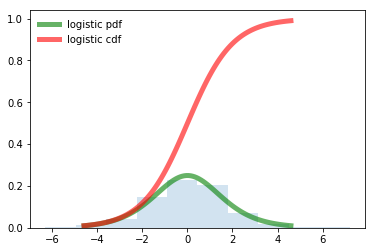

In [41]:
from scipy.stats import logistic
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
# Calculate a few first moments:
mean, var, skew, kurt = logistic.stats(moments='mvsk')
# Display the probability density function (``pdf``):
x = np.linspace(logistic.ppf(0.01),
                logistic.ppf(0.99), 100)
ax.plot(x, logistic.pdf(x),
       'g-', lw=5, alpha=0.6, label='logistic pdf')
ax.plot(x, logistic.cdf(x),
       'r-', lw=5, alpha=0.6, label='logistic cdf')
vals = logistic.ppf([0.001, 0.5, 0.999])
np.allclose([0.001, 0.5, 0.999], logistic.cdf(vals))
# True
# Generate random numbers:
r = logistic.rvs(size=1000)
# And compare the histogram:
ax.hist(r, normed=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

## Excercise 4

In case of small streams, storms and passing weather fronts with rain can significantly increase water discharge on a short time scale. Develop a simple algorithm to detect rainy events in the data. Plot the original time series and mark rainy events.

**Manually calculating the mean <br />
The formula for the mean: <br /> <b>$sum(n)/len(n)$</b>**

In [42]:
#Take the values
scores = [w for w in data['Discharge'].dropna()]

#Sum them up
sum_score = sum(scores)

#Find the number of observations
num_score = len(scores)

#Calculating the mean value
avg_score = sum_score/num_score


avg_score

#Here we can consider that the discharge of vater is not so big 

34.2528934384558

**Manually calculating the median**

In [44]:
scores = [w for w in data['Discharge'].dropna()]

num_score = len(scores)

sorted_scores = sorted(scores)

middle = int((num_score / 2) + 0.5)

print(sorted_scores[middle])  # 24

#We can see that the difference between mean and median is big. The reason behind it is anomalies

21.2


## Excercise 5

Water discharge increases significantly during rain producing maxima in the time series. Plot the distribution of maximum values and fit with an appropriate function. Bring arguments to support the choice of probabilistic model.

## Excercise 6

Once rainy events are detected, plot the distribution of the length of sunny intervals between rains. Fit the distribution with an appropriate function.

## Excercise 7

What is the maximum of water discharge in an arbitrarily chosen period of one year? Calculate the maximum of water discharge due to rain in a rolling window of 1 year, plot its distribution and fit with an appropriate function.

## Excercise 8

How many time does it rain in a month? Calculate and plot the distribution and fit with an appropriate function.

## Excercise 9

Find the measuring station you used in the excercises above on the map. Find another measurement station about 100-200 miles from it and download the data. Try to estimate the typical time it takes for weather fronts to travel the distance between the two measuring stations.